# Creating Baseline Model

## Importing necessary packages and Housing Data csv

In [1]:
import pandas as pd

# import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import linear_model, metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler 

df = pd.read_csv('../data/kc_house_data.csv')

## CLEANING THE DATA FOR THE ORIGINAL DATAFRAME

In [2]:
df = df.replace('?', np.nan)
df.sqft_basement = df.sqft_basement.replace('?', np.nan)
df.sqft_basement = df.sqft_basement.astype(float)
df = df.replace(np.nan, '0')

## Baseline Model Used Every Numerical Column from House Data

In [3]:
X = df[['sqft_living', 'sqft_lot', 'sqft_living15', 
        'sqft_lot15', 'sqft_above', 'bathrooms', 'bedrooms',  
        'lat', 'long', 'zipcode', 'grade', 'yr_built', 'yr_renovated', 
        'view', 'condition', 'grade', 'sqft_basement']]
y = df['price']

## MAKING FIRST TRAIN TEST SPLIT WITH ORIGINAL DF.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [5]:
lr = LinearRegression()
#linear regressor
lr.fit(X_train, y_train)
# Make predictions for train and test set
train_preds1 = lr.predict(X_train)
test_preds1 = lr.predict(X_test)

## Baseline model did not perform well with a low R-squared and a root mean squared error over 200,000 with a 10k difference between testing and training RMSE

In [6]:
print('R-squared Value {}'.format(lr.score(X_test, y_test)))
print('Training RMSE: {}'.format(np.sqrt(mse(y_train, train_preds1))))
print('Testing RMSE: {}'.format(np.sqrt(mse(y_test, test_preds1))))

R-squared Value 0.6749801766510155
Training RMSE: 205095.98689943543
Testing RMSE: 211169.66086557135


# Scaling and Logging features in an attempt to improve performance

## removes outliers by price greater than 3 z-scores away from mean

In [7]:
X_train['target'] = y_train
X_train_no = X_train[(np.abs(stats.zscore(X_train[['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'sqft_above', 
'bathrooms', 'bedrooms', 'target']])) < 3).all(axis=1)].drop_duplicates()
y_train_no = X_train_no['target']
X_train_no = X_train_no.drop('target', axis = 1)

<ipython-input-7-9191c68a1e51>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['target'] = y_train


## How logging price affects normalization of model

(array([  29.,   75.,  399., 1638., 3031., 3670., 3218., 2126.,  732.,
         339.]),
 array([11.26446411, 11.56903838, 11.87361264, 12.17818691, 12.48276118,
        12.78733545, 13.09190972, 13.39648399, 13.70105826, 14.00563253,
        14.3102068 ]),
 <BarContainer object of 10 artists>)

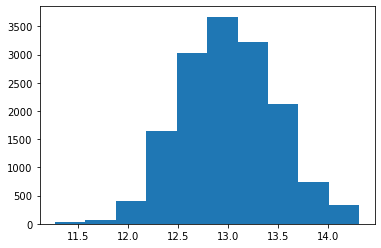

In [8]:
plt.hist(np.log(y_train_no))

In [9]:
#logging price
y_train_scaled = np.log(y_train_no)

In [10]:
# Make predictions for train and test set
train_preds2 = lr.predict(X_train_no)
test_preds2 = lr.predict(X_test)

In [11]:
print('R-squared Value {}'.format(lr.score(X_test, y_test)))
print('Training RMSE: {}'.format(np.sqrt(mse(np.exp(y_train_scaled), train_preds2))))
print('Testing RMSE: {}'.format(np.sqrt(mse(y_test, test_preds2))))

R-squared Value 0.6749801766510155
Training RMSE: 150397.61389619787
Testing RMSE: 211169.66086557135


## Despite improvement in training RMSE, difference between training and testing RMSE increased dramaticaly

# Developing the Final Model

In [12]:
df = pd.read_csv('../data/house_data_census.csv')

## Introducing Census Data

# [See this notebook](exploratory/johncarter/adding_census_data.ipynb)

## Cleaning Data for Final Model

In [13]:
df = df[df.tracts != '0']
#df = df.replace('?', np.nan) 
#df.sqft_basement = df.sqft_basement.astype(float)  #wound up being the only column that had '?'
#df = df.replace(np.nan, 0)
df.bedrooms[15856] = 3  # changing small home listed as having 33 bedrooms

In [14]:
df.bedrooms.unique()

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10])

## Creating three new columns to use in model

In [15]:
df['compared_to_neighbors'] = df['sqft_living']/df['sqft_living15']
df['empty_lot_space'] =  df['sqft_living'] / df['sqft_lot']
df['tract_num'] = df.tracts.str[5:]
df.tract_num  = df.tract_num.astype(int)

### Compared To Neighbors shows how much living space a home has compared to 15 nearest neighbors

### Empty Lot Space shows what percentage of property is non-residential

### Tract Num allows One Hot Encoding of homes by census tract 

## Train/Test split for final model


In [16]:
X = df.copy()
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)


## Features used in final model

In [17]:
numeric = ['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15','sqft_above', 
           'grade', 'condition','bathrooms', 'bedrooms', 'yr_built', 
           'compared_to_neighbors', 'empty_lot_space', 'MedianHous']

cats = ['tract_num']

## One Hot Encoding Categorical Features (tract_num)

In [18]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(X_train[cats])

X_train_encoded = ohe.transform(X_train[cats])
X_test_encoded = ohe.transform(X_test[cats])

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=ohe.get_feature_names())
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=ohe.get_feature_names())


## Scaling Numerical Features

In [19]:
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numeric]), columns=numeric)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric]), columns=numeric)

## concatinating categorical and numerical features

In [20]:
X_train_concat = pd.concat([X_train_scaled, X_train_encoded_df], axis=1)
X_test_concat = pd.concat([X_test_scaled, X_test_encoded_df], axis=1)

## Logging price

In [21]:
y_train = np.log(y_train)
y_test = np.log(y_test)

## How accurately does median household income from census data predict price?

In [22]:
def median_house(X, y, qant):
    quantiles = pd.DataFrame(pd.qcut(np.exp(y), q=qant))
    #e = np.exp(lr.predict(X)) - np.exp(y)
    quantiles['MedianHous'] = X['MedianHous']
    error_df = quantiles.groupby('price').mean()['MedianHous']
    error_df = pd.DataFrame(error_df).reset_index()
    plt.rcParams["figure.figsize"] = (20, 10)
    figure =  error_df.plot.bar(x='price', y='MedianHous', rot=45)
    plt.ylabel("Median Household Income ($)", fontsize=15)
    plt.xlabel("Home Price Quantiles ($)", fontsize=15)
    plt.title('How Census Tract Median Household Income Aligns with Home Price Quantiles', fontsize=20)
    plt.ylim(bottom=60000)
    return figure

## Census Tract Median Household Income is extremely indicative of home price

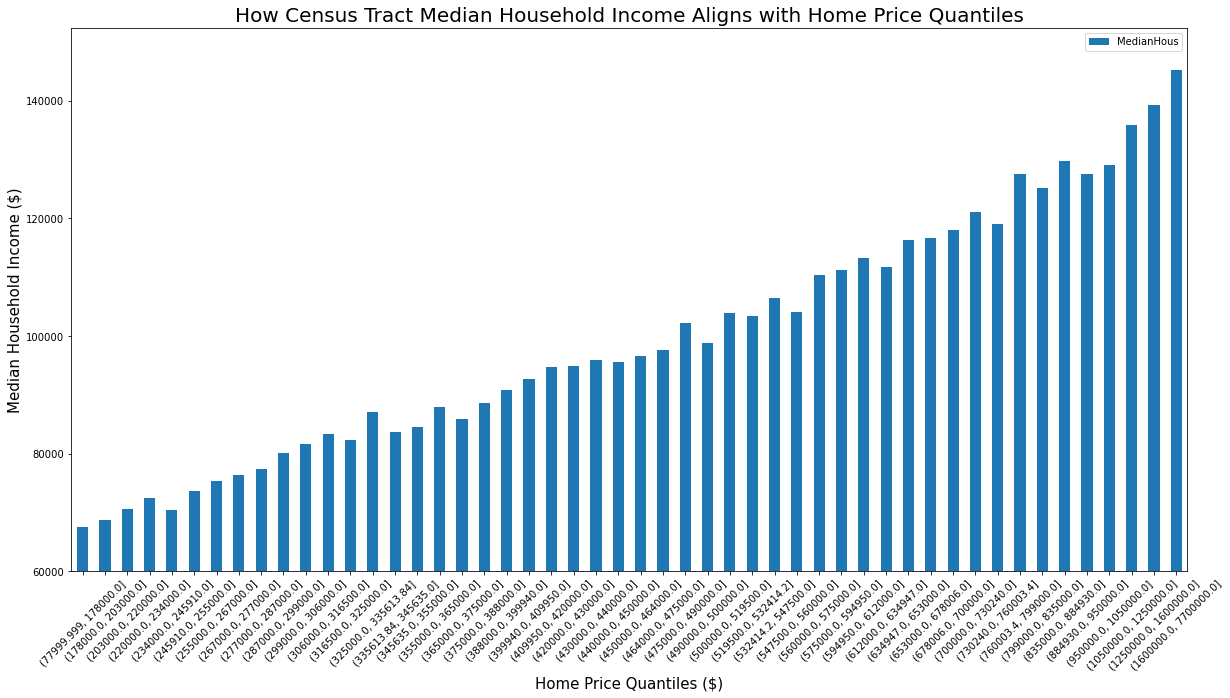

In [23]:
median_house(X_train, y_train, 50);

## Ensuring feature and target lengths are the same

In [24]:
print('Training features length: ', len(X_train_concat))
print('Testing features length: ', len(X_test_concat))
print('Training target length: ', len(y_train))
print('Testing target length: ', len(y_test))

Training features length:  16178
Testing features length:  5393
Training target length:  16178
Testing target length:  5393


In [27]:
lr.fit(X_train_concat, y_train)
train_preds = lr.predict(X_train_concat)
test_preds = lr.predict(X_test_concat)

## Testing final model

In [28]:
print("r squared", lr.score(X_test_concat, y_test))
train_error = mean_squared_error(np.exp(y_train), np.exp(train_preds), squared = False)
test_error = mean_squared_error(np.exp(y_test), np.exp(test_preds), squared = False)

print("train error", train_error)
print("test error", test_error)

r squared 0.880486057172617
train error 137156.26036227675
test error 137393.08508043113


## Much Better! The Final Model has an R-squared of .88 and a train/test error difference of less than 300.  Further exploration can determine where the majority of error is found.

In [29]:
def quantile_error(X, y, qant):

    quantiles = pd.DataFrame(pd.qcut(np.exp(y), q=qant))
    e = np.exp(lr.predict(X)) - np.exp(y)
    quantiles['error'] = e
    error_df = quantiles.groupby('price').mean()['error']
    error_df = pd.DataFrame(error_df).reset_index()
    plt.rcParams["figure.figsize"] = (20, 10)
    figure =  error_df.plot.bar(x='price', y='error', rot=45)
    plt.yticks([-150000, -100000, -50000, -20000, 0, 20000, 50000])
    plt.ylabel("Amout of Error ($)", fontsize=15)
    plt.xlabel("Home Price Quantiles ($)", fontsize=15)
    plt.title('How Error is Dispersed Among Home Price Quantiles', fontsize=20)
    return figure

## Graph shows the vast majority of error occurrs with homes sold for less than 100,000 dollars or greater than 2m dollars.

<AxesSubplot:title={'center':'How Error is Dispersed Among Home Price Quantiles'}, xlabel='Home Price Quantiles ($)', ylabel='Amout of Error ($)'>

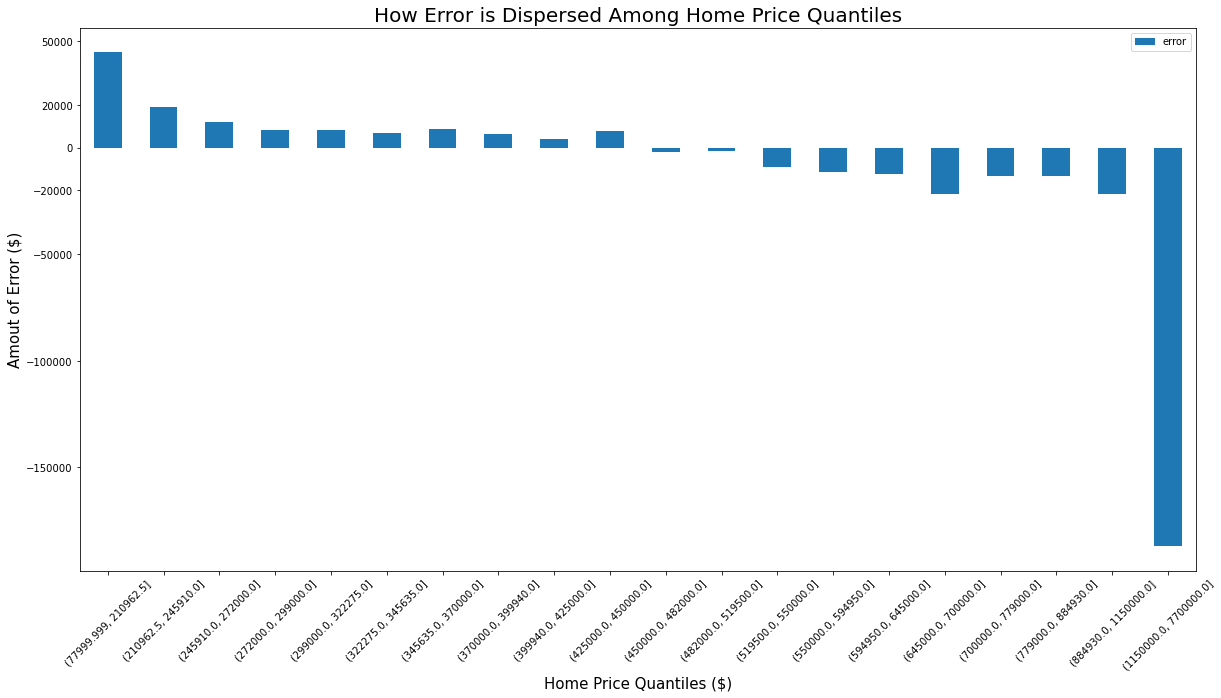

In [30]:
quantile_error(X_train_concat, y_train, 20)

## Thankfully the vast majority of houses fall well within this price range

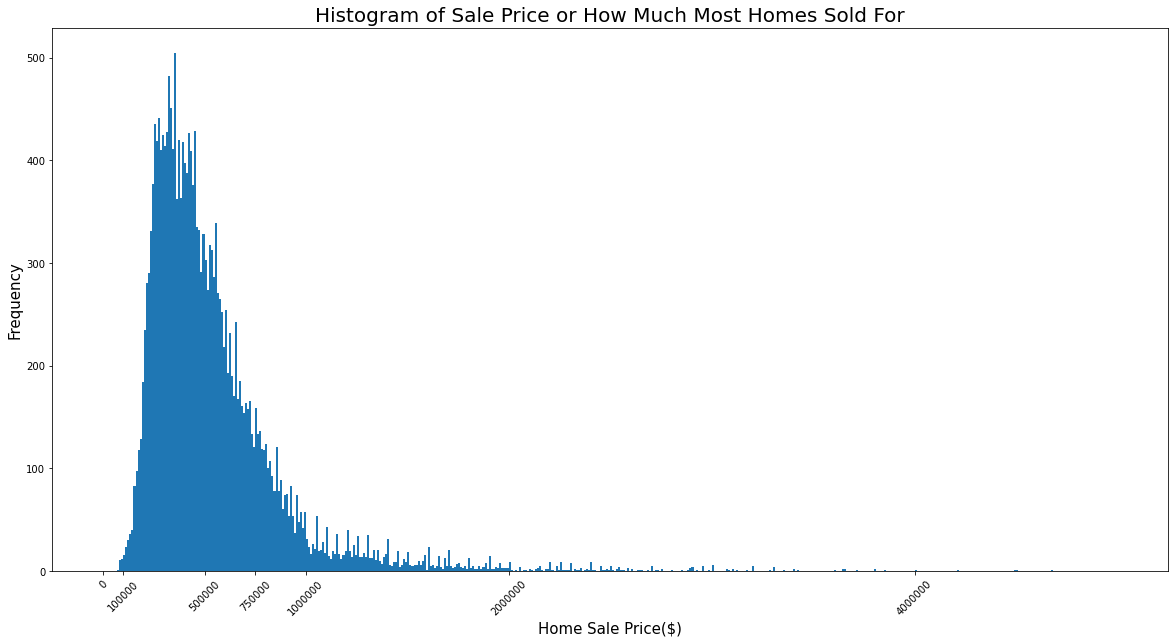

In [104]:
fig, ax = plt.subplots()
plt.hist('price', bins=500, data=df, range=(0,5000000));
ax.ticklabel_format(style='plain')
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Home Sale Price($)", fontsize=15)
plt.title('Histogram of Sale Price or How Much Most Homes Sold For', fontsize=20)
plt.xticks(ticks=[0,100000,500000,750000,1000000,2000000,4000000], rotation=45);

## Features ranked by order of importance.

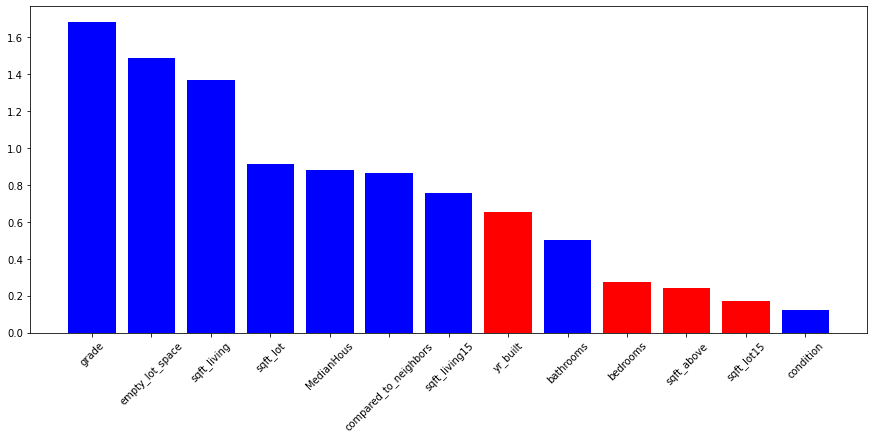

In [105]:
def feature_importance(model, X, num=20):
    features = list(X.columns)
    feature_weight = pd.DataFrame(features, columns=['feature'])
    feature_weight['coef'] = model.coef_
    feature_weight['coef_abs'] = np.abs(model.coef_)
    importance = feature_weight.sort_values('coef_abs', ascending=False).iloc[:num]
    plt.figure(figsize=(15,6))
    colors = ['blue' if x > 0 else 'red' for x in importance.coef]
    plt.bar(importance["feature"], importance['coef_abs'], color=colors)
    plt.xticks(rotation=45)
    return importance
importance = feature_importance(lr.fit(X_train_scaled, y_train), X_train_scaled)